In [1]:
#Imports

# general imports
import numpy as np
import mkl
import sys
from scipy import ndimage as ndi

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline


# required omsi-specific modules:
def isneeded(x):
    if x not in sys.path:
        sys.path.append(x)

isneeded('/Users/curt/openMSI_SVN/openmsi-tk/')
from omsi.dataformat.mzml_file import *
from omsi.analysis.findpeaks.omsi_findpeaks_local import *

# timing
import time

# midas-specific modules:
isneeded('/Users/curt/PycharmProjects/MIDAS_remote/')
import MIDAS

ImportError: cannot import name rdBase

In [2]:
omsi_ms2 = mzml_file(basename="/Users/curt/openMSI_localdata/re-reimaging_TI.mzML")

Read 2806 scans from mzML file.
Found 3 different scan types in mzML file.
Processed data for 0 spectra to datacube for scan type ITMS + p MALDI Z ms2 907.73@cid60.00 [500.00-700.00]
Processed data for 1000 spectra to datacube for scan type ITMS + p MALDI Z ms2 907.73@cid60.00 [500.00-700.00]
Processed data for 2000 spectra to datacube for scan type ITMS + p MALDI Z ms2 907.73@cid60.00 [500.00-700.00]
Processed data for 0 spectra to datacube for scan type FTMS + p MALDI Full ms [850.00-1000.00]
Processed data for 1000 spectra to datacube for scan type FTMS + p MALDI Full ms [850.00-1000.00]
Processed data for 2000 spectra to datacube for scan type FTMS + p MALDI Full ms [850.00-1000.00]
Processed data for 0 spectra to datacube for scan type ITMS + p MALDI Z ms2 906.76@cid60.00 [500.00-700.00]
Processed data for 1000 spectra to datacube for scan type ITMS + p MALDI Z ms2 906.76@cid60.00 [500.00-700.00]
Processed data for 2000 spectra to datacube for scan type ITMS + p MALDI Z ms2 906.76

(623, 629)

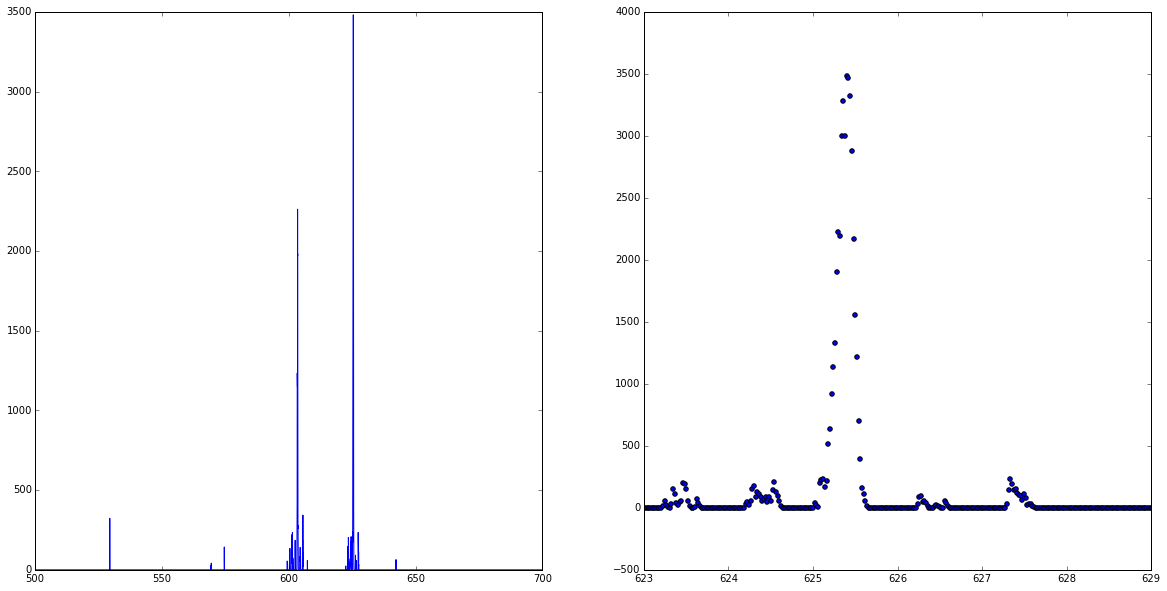

In [3]:
# picking a pixel from the first MS2 datacube:

nx, ny, nz = omsi_ms2.data[0].shape
x, y = np.unravel_index(omsi_ms2.data[0][:, :, :].sum(axis=2).argmax(), dims = (nx, ny))
mz, ints = omsi_ms2.mz_all[0], omsi_ms2.data[0][x, y, :]

f, ax = plt.subplots(1, 2, figsize=[20, 10])
ax[0].plot(mz, ints)
ax[1].scatter(mz, ints)
ax[1].set_xlim([623, 629])

Peak finding with smoothwidth 2 and slwindow 3 took 0.0791611671448 seconds.
Peak finding with smoothwidth 2 and slwindow 5 took 0.0396590232849 seconds.
Peak finding with smoothwidth 2 and slwindow 8 took 0.0403590202332 seconds.
Peak finding with smoothwidth 2 and slwindow 10 took 0.0394010543823 seconds.
Peak finding with smoothwidth 3 and slwindow 3 took 0.0451958179474 seconds.
Peak finding with smoothwidth 3 and slwindow 5 took 0.0504767894745 seconds.
Peak finding with smoothwidth 3 and slwindow 8 took 0.0577099323273 seconds.
Peak finding with smoothwidth 3 and slwindow 10 took 0.042487859726 seconds.
Peak finding with smoothwidth 4 and slwindow 3 took 0.0432097911835 seconds.
Peak finding with smoothwidth 4 and slwindow 5 took 0.0611689090729 seconds.
Peak finding with smoothwidth 4 and slwindow 8 took 0.0578849315643 seconds.
Peak finding with smoothwidth 4 and slwindow 10 took 0.04984998703 seconds.
Peak finding with smoothwidth 8 and slwindow 3 took 0.0594849586487 seconds.

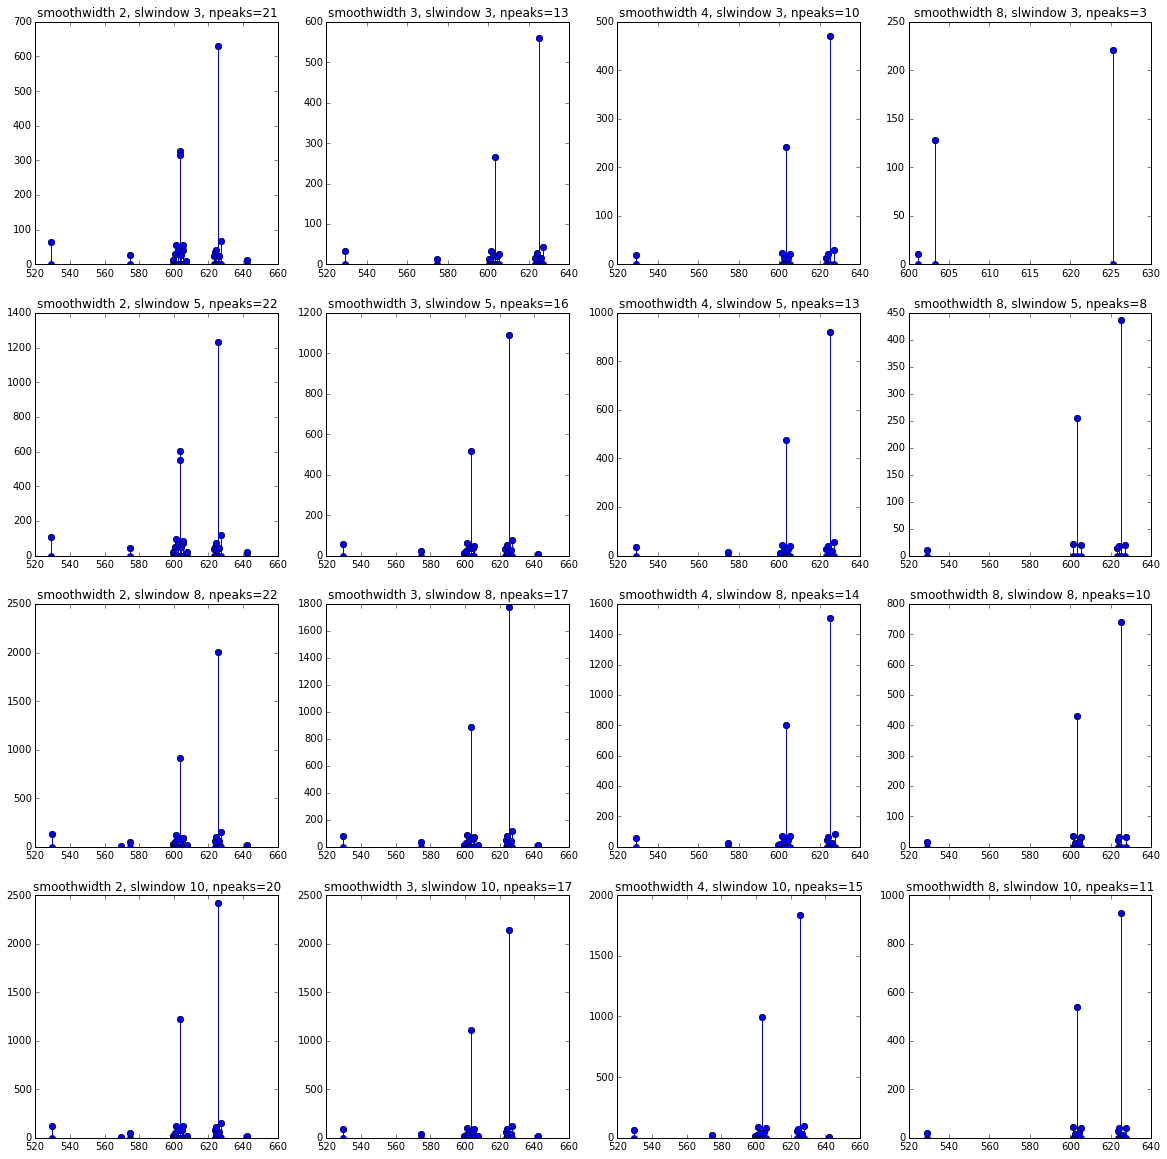

In [4]:
# finding peaks in the chosen pixel:
fpl = omsi_findpeaks_local(name_key='local pk finding example')

swidths = [2, 3, 4, 8]
slwins = [3, 5, 8, 10]
npks = []
pklocs = []
pkvals = []

#since fpl.execute() expects a datacube we use np.expand_dims() pad with extra singleton dimensions

f, axarr = plt.subplots(4, 4, figsize = (20, 20)) #length of each swidths and slwins is 4
for ix, swidth in enumerate(swidths):
    for iy, slwin in enumerate(slwins):
        start = time.time()
        
        peakmz, peakval, peakidx, data =\
            fpl.execute(msidata=ints[np.newaxis, np.newaxis, :], mzdata=mz, peakheight=10, 
                        smoothwidth=swidth, slwindow=slwin, printStatus=True)
        stop = time.time()
  
        print "Peak finding with smoothwidth %s and slwindow %s took %s seconds." % (swidth, slwin, stop-start)
        
        npks.append(peakmz.shape[0])
        pklocs.append(mz[peakmz])
        pkvals.append(peakval)
        
        axarr[iy, ix].stem(mz[peakmz], peakval, 'b-o')
        axarr[iy, ix].set_title('smoothwidth %s, slwindow %s, npeaks=%s' % (swidth, slwin, peakmz.shape[0]))

In [5]:
# from the above analysis it appears that for this pixel in this datacube, 
## smoothwidth should be 8, and slwindow should be 5 or higher


# using these parameters we get data suitable for executing MIDAS
peakmz, peakval, peakidx, data = fpl.execute(msidata=ints[np.newaxis, np.newaxis, :], mzdata=mz, peakheight=10, 
                        smoothwidth=8, slwindow=10, printStatus=True)


midas_dat = np.asarray(zip(mz[peakmz], peakval))

print midas_dat

[[ 529.33898926   20.79384583]
 [ 601.24945068   45.5407152 ]
 [ 602.42700195   13.69110933]
 [ 603.34509277  540.61481599]
 [ 604.40289307   20.86316005]
 [ 605.42077637   40.70969638]
 [ 623.36346436   29.39040963]
 [ 624.30151367   39.15407602]
 [ 625.29943848  926.65900761]
 [ 626.25744629   11.76622797]
 [ 627.33520508   41.40666898]]


In [ ]:
scanlist = []
defaultcharge = 1

scan_types = ['ITMS + p MALDI Z ms2 907.73@cid60.00 [500.00-700.00]']

#initialize all peakcubes and peakmzs as appropriate-length lists of empty numpy arrays
peakcube = [midas_dat[np.newaxis, np.newaxis, :, 1] for scantype in [1]]


peakmz = [midas_dat[:, 0] for scantype in [1]]  

for ix, scan in enumerate(scan_types):  #enumerate(ms2img.scan_types)
    
    #only work on MS2 scans
    if True: #scan.find('ms2')!=-1:
        
        #find peakcube from datacube using findpeaks_global
        #ms2pks = omsi_findpeaks_global(name_key = 'finding global peaks')
        #ms2img.peakcube[ix], ms2img.peakmz[ix] = ms2pks.execute(msidata=ms2img.data[ix], \
                                                                #mzdata=ms2img.mz[ix],\
                                                                #slwindow=10, smoothwidth=2)
        
        #read all MS2 speaks
        nx, ny, nmz = peakcube[ix].shape  
        print "Reading peakcube with shape (%s, %s, %s)" % (nx, ny, nmz)
        for x in np.arange(nx):
            for y in np.arange(ny):
                current_peaks_list = np.zeros(shape=(peakmz[ix].shape[0], 3), dtype=float)
                current_peaks_list[:, 0] = peakmz[ix]
                current_peaks_list[:, 1] = peakcube[ix][x, y, :]
                scanlist.append(current_peaks_list)
                
                #for now, just get precursor mass from scan filter string
                ## eventually this should be found by inspecting MS2 or MS1 spectra 
                dPrecursorMofZ = float(filter(None, re.findall('[\d.]+(?=@)', scan))[0])              
                
                protonmass = 1.00782503207 - 5.4857990946e-4
                chargestate = defaultcharge
                scanlist.append(dPrecursorMofZ-chargestate*protonmass)
                scanlist.append(ix*(x*nx+y)) #scan number as image location
                scanlist.append(chargestate)
                scanlist.append(dPrecursorMofZ)
                scanlist.append(0) #retention time
                scanlist.append('') #sScanHead, probably not needed

print scanlist